In [75]:
#allow autoreload modules at every execution if requested
%load_ext autoreload

import tempfile
import unittest

from pathlib import Path

import numpy as np
import pandas as pd

from cs_parser import CsParser, mappings
from star_parser import StarTabDf, StarParser

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [76]:
%autoreload 2
work_folder = Path("/mnt/DATA/andrea/AM_20211112_NeCen_BRCA1AUb")
test_file = work_folder/"J89_particles_accepted.cs"
swapxy = True
inverty = True
invertx = False
remove_particles_from_border = False
box_size = 624
mic_size_x = 11520
mic_size_y = 8184
crop_factor = 1 # coordinates are multiplied by this number. 1 => same crop factor on motioncorrection for relion and cryosparc. 2 => uncropped relion, cryosparc crop 2
assert test_file.exists()
destination_file = work_folder/"J89_particles_selected.star"
remove_cryosparc_suffix = False # remove _patch_aligned_doseweighted
job_id = "J31"
remove_cryosparc_prefix= True #remove <job_id>/motioncorrected/<micrograph uid>_


parser = CsParser(test_file)
array = parser.parse_array()

In [77]:
from pprint import pprint
a = array.cs_array.copy()
dtypes = a.dtype.fields
problematic = []
clean = []
for index, value in enumerate(list(a[0])):
    if isinstance(value, np.ndarray):
        key = list(a.dtype.fields.keys())[index]
        problematic.append(key)
    else:
        key = list(a.dtype.fields.keys())[index]
        clean.append(key)

In [78]:
mapping_coords = {0:'x', 1:'y', 2:'z'}
mapping_angles = {0:'alpha', 1:'beta', 2:'gamma'}
rascals = a[problematic]
index_column = range(a.shape[0])
reformed = pd.DataFrame(index_column)
# make dummy zero array column
# reformed = np.zeros((rascals[problematic[0]].shape[0], 1))
for key in problematic:
    #if the name of the column is poses, they are angles;
    #otherwise they are shifts
    if 'pose' in key:
        mapping = mapping_angles
    else:
        mapping = mapping_coords
    #split the array into a list of n single columns
    split_arrays = np.hsplit(rascals[key], rascals[key].shape[-1])
    #rename their index
    for index, array in enumerate(split_arrays):
        try:
            new_dtype = (f'{key}_{mapping[index]}')
        except KeyError:
            continue
        reformed[new_dtype] = pd.DataFrame(array)

In [79]:
good = a[clean]
df = pd.DataFrame(good)
new_columns = []
for c in df.columns:
    if c in mappings and mappings[c]:
        new_columns.append(mappings[c])
    else:
        new_columns.append(c)
df.columns = new_columns

In [80]:
frac_coords = df[['FracCoordinateX','FracCoordinateY']]
mic_size = reformed[['location/micrograph_shape_x','location/micrograph_shape_y']]
abs_coords = pd.DataFrame()
#this version of pandas complains about chained assignment even though it does not have a chained assignment
pd.set_option('mode.chained_assignment', None)
if invertx:
    frac_coords.loc[:, 'FracCoordinateX'] = 1 -frac_coords.loc[:,'FracCoordinateX']
if inverty:
    frac_coords.loc[:, 'FracCoordinateY'] = 1- frac_coords.loc[:,'FracCoordinateY']
pd.set_option('mode.chained_assignment', 'warn')
if swapxy:
    abs_coords['CoordinateX'] = pd.DataFrame(frac_coords['FracCoordinateX'] * reformed['location/micrograph_shape_y'])
    abs_coords['CoordinateY'] = pd.DataFrame(frac_coords['FracCoordinateY'] * reformed['location/micrograph_shape_x'])
    abs_coords = abs_coords * crop_factor
    abs_coords = abs_coords.applymap(np.rint).astype(int)
else:
    abs_coords['CoordinateX'] = pd.DataFrame(frac_coords['FracCoordinateX'] * reformed['location/micrograph_shape_x'])
    abs_coords['CoordinateY'] = pd.DataFrame(frac_coords['FracCoordinateY'] * reformed['location/micrograph_shape_y'])
    abs_coords = abs_coords * crop_factor
    abs_coords = abs_coords.applymap(np.rint).astype(int)
abs_coords


,CoordinateX,CoordinateY
0,2403,251
1,4599,212
2,4756,401
3,3336,613
4,4072,567
...,...,...
8906,3755,2454
8907,5471,2846
8908,5528,3124
8909,4935,3510


In [81]:
df[abs_coords.columns] = abs_coords
for column in ['ImageName', 'MicrographName']:
    try:
        df[column] = df[column].str.decode('utf-8')
    except KeyError:
        pass

In [82]:
df = df.astype(str)
starparser = StarParser(destination_file, create=True)
data = starparser.read_df(df)
data['data_'].to_df()

,uid,MicrographUid,OpticsGroup,MicrographName,FracCoordinateX,FracCoordinateY,CoordinateX,CoordinateY
0,4075758711771548031,7426128884927229762,0,J31/motioncorrected/007426128884927229762_Foil...,0.41716635,0.9386524,2403,251
1,11718905519999321057,7426128884927229762,0,J31/motioncorrected/007426128884927229762_Foil...,0.7985075,0.9482825,4599,212
2,12510369281885338817,7426128884927229762,0,J31/motioncorrected/007426128884927229762_Foil...,0.8256516,0.90205353,4756,401
3,10012758233569544447,7426128884927229762,0,J31/motioncorrected/007426128884927229762_Foil...,0.57918024,0.8502971,3336,613
4,13180665266575057916,7426128884927229762,0,J31/motioncorrected/007426128884927229762_Foil...,0.70686793,0.86140716,4072,567
...,...,...,...,...,...,...,...,...
8906,2357709693412832176,5615414945998944678,0,J31/motioncorrected/005615414945998944678_Foil...,0.6518495,0.40041164,3755,2454
8907,3499244496110287145,5615414945998944678,0,J31/motioncorrected/005615414945998944678_Foil...,0.9498107,0.3045737,5471,2846
8908,17102760601349044606,5615414945998944678,0,J31/motioncorrected/005615414945998944678_Foil...,0.9597553,0.23645452,5528,3124
8909,9221362775957300696,5615414945998944678,0,J31/motioncorrected/005615414945998944678_Foil...,0.85685277,0.14228907,4935,3510


In [83]:
tab = data['data_']
tab.keep_only_columns(['MicrographName','CoordinateX','CoordinateY'], store=True)

,MicrographName,CoordinateX,CoordinateY
0,J31/motioncorrected/007426128884927229762_Foil...,2403,251
1,J31/motioncorrected/007426128884927229762_Foil...,4599,212
2,J31/motioncorrected/007426128884927229762_Foil...,4756,401
3,J31/motioncorrected/007426128884927229762_Foil...,3336,613
4,J31/motioncorrected/007426128884927229762_Foil...,4072,567
...,...,...,...
8906,J31/motioncorrected/005615414945998944678_Foil...,3755,2454
8907,J31/motioncorrected/005615414945998944678_Foil...,5471,2846
8908,J31/motioncorrected/005615414945998944678_Foil...,5528,3124
8909,J31/motioncorrected/005615414945998944678_Foil...,4935,3510


<AxesSubplot:>

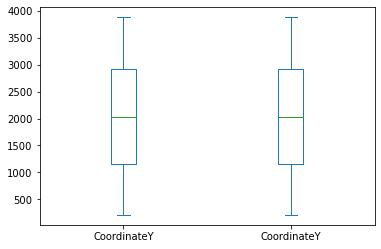

In [84]:
tab.to_df()[['CoordinateY', 'CoordinateY']].astype(int).plot(kind='box')

In [85]:
if remove_cryosparc_prefix:
    tab.trim_column_values('MicrographName', len("J31/motioncorrected/008686401862656547089_"), store=True)
    for l in tab.to_df()['MicrographName']:
        assert l.startswith('FoilHole') 

In [86]:
if remove_cryosparc_suffix:
    tab.remove_string_from_column_name('_patch_aligned_doseweighted', 'MicrographName', store=True)["MicrographName"][0]

In [87]:
tab.df = tab.to_df().astype(str)
starparser.write_out(to_file=True)

Data written to /mnt/DATA/andrea/AM_20211112_NeCen_BRCA1AUb/J89_particles_selected.star


In [88]:
split = tab.to_df().groupby('MicrographName')
split_dir = work_folder/'cryolo_train/train_annotations'
if not split_dir.exists():
    split_dir.mkdir()
for fname, data in split:
    x = StarTabDf(data)
    fname = fname.replace('.mrc','.star')
    with open(split_dir/fname, 'w') as f:
        f.write(x.to_star())